<a href="https://colab.research.google.com/github/vvamsi91/IML_AS6/blob/main/IML_AS6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Housing_data = pd.read_csv("https://raw.githubusercontent.com/vvamsi91/IML_AS6/main/Housing%20(2).csv")

Housing_data.head()              # Display the first 5 rows of the DataFrame

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
Housing_data['furnishingstatus'].value_counts().unique
Housing_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:

Housing_data = pd.get_dummies(Housing_data, columns=['furnishingstatus'], drop_first=False)
Housing_data = Housing_data.drop('furnishingstatus_semi-furnished', axis=1)
Housing_data.head()





,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,1,0
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,1,0
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,0,0
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,1,0
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,1,0


In [ ]:

binary_columns = Housing_data.select_dtypes(include=['object']).columns
print(binary_columns)


Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea'],
      dtype='object')


In [ ]:

Housing_data[binary_columns] = Housing_data[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))
Housing_data.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [ ]:
Housing_data.shape

(545, 14)

In [ ]:

from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [ ]:

X = Housing_data.drop('price', axis = 1)
y = Housing_data[['price']]


In [ ]:

X = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns, index=X.index).values
y = pd.DataFrame(scaler_y.fit_transform(y), columns=y.columns, index=y.index).values

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(train_X)
y_train =  torch.tensor(train_Y)
X_val =  torch.tensor(val_X)
y_val =  torch.tensor(val_Y)


In [ ]:

training_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [ ]:

val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=32)

In [ ]:

def model_train(model, criterion, optimizer, epochs, train_loader, X_val, y_val):
    loss_train = []
    loss_val = []
    for epoch in range(epochs + 1):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            if epoch % 500 == 0:
              print(f'Epoch {epoch}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
              loss_val.append(val_loss)
              loss_train.append(loss)
    return loss_train, loss_val

In [ ]:

model1 = nn.Sequential(nn.Linear(X_train.shape[1], 32), nn.Tanh(), nn.Linear(32, 1)).to(torch.float64)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
train_loss, val_loss = model_train(model1, nn.MSELoss(), optimizer1, 5000, train_loader, X_val, y_val)


Epoch 0/5000, Training Loss: 0.08487671455304975, Validation Loss: 0.1074777788405618
Epoch 500/5000, Training Loss: 0.01883656621787861, Validation Loss: 0.013091098102370266
Epoch 1000/5000, Training Loss: 0.00533655294734829, Validation Loss: 0.013253666282905075
Epoch 1500/5000, Training Loss: 0.005995257038924257, Validation Loss: 0.01311311927025946
Epoch 2000/5000, Training Loss: 0.006844031325138379, Validation Loss: 0.013121316769447344
Epoch 2500/5000, Training Loss: 0.00917780204537498, Validation Loss: 0.013105923638660592
Epoch 3000/5000, Training Loss: 0.002673123266725205, Validation Loss: 0.013069465433901757
Epoch 3500/5000, Training Loss: 0.011673373511882504, Validation Loss: 0.013025360421635638
Epoch 4000/5000, Training Loss: 0.0032230750847415763, Validation Loss: 0.013060161460798313
Epoch 4500/5000, Training Loss: 0.006899410070813507, Validation Loss: 0.013060384837382769
Epoch 5000/5000, Training Loss: 0.005798656227422404, Validation Loss: 0.01307232838663153

In [ ]:
for name, param in model1.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([1, 32])
Parameter name: 2.bias, Shape: torch.Size([1])


In [ ]:
total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  481 



In [ ]:
epochs = range(0, 5001, 500)
print(epochs)

range(0, 5001, 500)


<ipython-input-90-20ac4f53b197>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


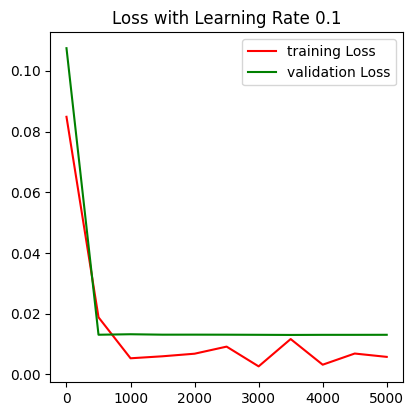

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Loss for optimizer SGD')

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss]), color='red', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss]), color='green', label = 'validation Loss')
plt.title('Loss with Learning Rate 0.1')
plt.legend()


plt.show()

In [ ]:
model2 = nn.Sequential(nn.Linear(X_train.shape[1], 32), nn.Tanh(), nn.Linear(32, 64), nn.Tanh(), nn.Linear(64, 16), nn.Tanh(), nn.Linear(16, 1)).to(torch.float64)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
train_loss_2, val_loss_ = model_train(model2, nn.MSELoss(), optimizer2, 5000, train_loader, X_val, y_val)


Epoch 0/5000, Training Loss: 0.03531131913714376, Validation Loss: 0.0672740324138822
Epoch 500/5000, Training Loss: 0.01006276226804732, Validation Loss: 0.013295044968324222
Epoch 1000/5000, Training Loss: 0.005478295480310104, Validation Loss: 0.013501536981402296
Epoch 1500/5000, Training Loss: 0.003132740551203211, Validation Loss: 0.01351533506828888
Epoch 2000/5000, Training Loss: 0.008331283854352743, Validation Loss: 0.013535034777452095
Epoch 2500/5000, Training Loss: 0.006037653685665825, Validation Loss: 0.013487176927502419
Epoch 3000/5000, Training Loss: 0.005745390493240644, Validation Loss: 0.013497670109437367
Epoch 3500/5000, Training Loss: 0.0029214786074695477, Validation Loss: 0.013633992674020299
Epoch 4000/5000, Training Loss: 0.0032676144885950727, Validation Loss: 0.013560977100597766
Epoch 4500/5000, Training Loss: 0.01192040904363591, Validation Loss: 0.013616935921180242
Epoch 5000/5000, Training Loss: 0.006946176915992199, Validation Loss: 0.013593679954921

In [ ]:
for name, param in model1.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")


Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([1, 32])
Parameter name: 2.bias, Shape: torch.Size([1])


In [ ]:

total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  481 



In [ ]:

epochs = range(0, 5001, 500)
print(epochs)


range(0, 5001, 500)


<ipython-input-96-77f1287e2fd2>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


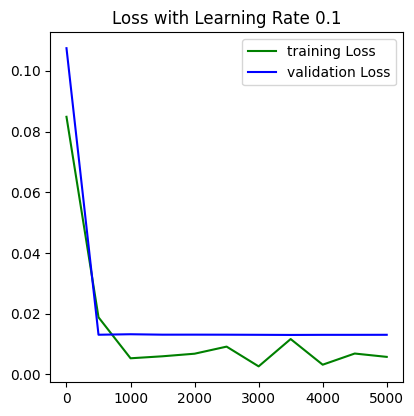

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Loss for optimizer SGD')

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss]), color='green', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss]), color='blue', label = 'validation Loss')
plt.title('Loss with Learning Rate 0.1')
plt.legend()

plt.show()
